<a href="https://colab.research.google.com/github/matusoff/ML_models/blob/main/LTSM_RNA_csv_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv('/content/sample_data/rheumatoid_arthritis_merged_inner_14052024.csv')
data.head()

,RNA_Symbol,Category,Species,Disease Name,Score,Sequence,Structure,Min Energy,Seq Length
0,hsa-miR-126-3p,miRNA,Homo sapiens,Rheumatoid Arthritis,1.000000,UCGUACCGUGAGUAAUAAUGCG,.((((..((.....))..)))),-0.7,22
1,hsa-miR-146a-5p,miRNA,Homo sapiens,Rheumatoid Arthritis,1.000000,UGAGAACUGAAUUCCAUGGGUU,....((((.(......).)))),-0.7,22
2,hsa-miR-221-3p,miRNA,Homo sapiens,Rheumatoid Arthritis,1.000000,AGCUACAUUGUCUGCUGGGUUUC,(((..........))).......,-1.3,23
3,hsa-miR-155-3p,miRNA,Homo sapiens,Rheumatoid Arthritis,1.000000,CUCCUACAUAUUAGCAUUAACA,......................,0.0,22
4,hsa-miR-155-3p,miRNA,Homo sapiens,Rheumatoid Arthritis Susceptibility,0.694506,CUCCUACAUAUUAGCAUUAACA,......................,0.0,22


In [ ]:
# Find a specific RNA sequence and print its associated row
rna_to_find = 'GAS5'
specific_row = data.loc[data['RNA_Symbol'] == rna_to_find]

# Print the specific row
print(specific_row)

   RNA_Symbol Category       Species          Disease Name  Score  \
41       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
42       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
43       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
44       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
45       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
46       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
47       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
48       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
49       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
50       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
51       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
52       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
53       GAS5   lncRNA  Homo sapiens  Rheumatoid Arthritis    1.0   
54       GAS5   lncRNA  Homo sapie

6926


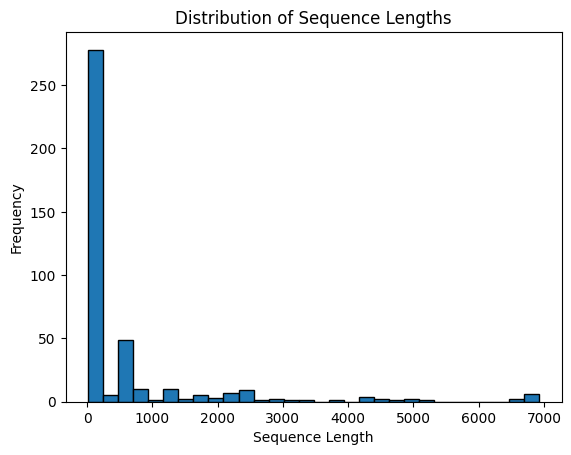

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

print(data['Seq Length'].max())

# Plot the length distribution
plt.hist(data['Seq Length'], bins=30, edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Masking, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to load sequences and structures from a CSV file
def load_sequences_from_csv(file_path):
    data = pd.read_csv(file_path)
    sequences = data['Sequence'].tolist()
    structures = data['Structure'].tolist()
    seq_lengths = data['Seq Length'].tolist()
    headers = data['RNA_Symbol'].tolist()
    return headers, sequences, structures, seq_lengths

# Clean the structure data to ensure it contains only valid characters
def clean_structure_data(structures):
    valid_chars = {'.', '(', ')'}
    cleaned_structures = []
    for struct in structures:
        cleaned_structures.append(''.join([char if char in valid_chars else '.' for char in struct]))
    return cleaned_structures

# Function to encode and pad sequences and structures
def encode_and_pad(items, label_encoder, max_length=None):
    encoded_items = [label_encoder.transform(list(item)) for item in items]
    if max_length is None:
        max_length = max(len(item) for item in encoded_items)
    padded_items = pad_sequences(encoded_items, maxlen=max_length, padding='post')
    one_hot_items = np.array([to_categorical(item, num_classes=len(label_encoder.classes_)) for item in padded_items])
    return one_hot_items, max_length

# Load and preprocess the data
file_path = '/content/sample_data/rheumatoid_arthritis_merged_inner_14052024.csv'
headers, sequences, structures, seq_lengths = load_sequences_from_csv(file_path)

# Clean the structure data
structures = clean_structure_data(structures)

# Create label encoders
nucleotide_le = LabelEncoder()
nucleotide_le.fit(['A', 'U', 'G', 'C', 'N'])
structure_le = LabelEncoder()
structure_le.fit(list('.()'))

# Encode and pad sequences and structures
X_lstm, max_seq_length = encode_and_pad(sequences, nucleotide_le)
y_lstm, max_struct_length = encode_and_pad(structures, structure_le, max_seq_length)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp, headers_train, headers_temp = train_test_split(X_lstm, y_lstm, headers, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, headers_val, headers_test = train_test_split(X_temp, y_temp, headers_temp, test_size=0.5, random_state=42)

# Define the LSTM model with additional features
sequence_input = Input(shape=(max_seq_length, X_lstm.shape[2]), name='sequence_input')
structure_input = Input(shape=(max_seq_length, y_lstm.shape[2]), name='structure_input')

masked_sequence = Masking(mask_value=0)(sequence_input)
masked_structure = Masking(mask_value=0)(structure_input)

# Convolutional Layer for sequence input
conv_layer = Conv1D(filters=64, kernel_size=7, activation='relu')(masked_sequence)
conv_layer = Dropout(0.2)(conv_layer)
conv_layer = Conv1D(filters=64, kernel_size=7, activation='relu')(conv_layer)
pooled_conv_layer = GlobalMaxPooling1D()(conv_layer)

# Recurrent Layer for structure input
lstm_layer = Bidirectional(LSTM(100, return_sequences=True))(masked_structure)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = Bidirectional(LSTM(50, return_sequences=True))(lstm_layer)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = Bidirectional(LSTM(25, return_sequences=True))(lstm_layer)
pooled_lstm_layer = GlobalMaxPooling1D()(lstm_layer)

# Use Dense layers to ensure both tensors have the same number of units
dense_conv_layer = Dense(128, activation='relu')(pooled_conv_layer)
dense_lstm_layer = Dense(128, activation='relu')(pooled_lstm_layer)

# Concatenate the pooled features
attention_combined = Concatenate()([dense_conv_layer, dense_lstm_layer])

# Output Layers
region_output = Dense(1, activation='sigmoid', name='region_output')(attention_combined)
functional_effect_output = Dense(3, activation='softmax', name='functional_effect_output')(attention_combined)
off_target_output = Dense(1, activation='sigmoid', name='off_target_output')(attention_combined)
secondary_structure_output = TimeDistributed(Dense(y_lstm.shape[2], activation='softmax'), name='secondary_structure_output')(lstm_layer)

# Model Definition
model = Model(inputs=[sequence_input, structure_input], outputs=[region_output, functional_effect_output, off_target_output, secondary_structure_output])
model.compile(optimizer='adam',
              loss={'region_output': 'binary_crossentropy',
                    'functional_effect_output': 'sparse_categorical_crossentropy',
                    'off_target_output': 'binary_crossentropy',
                    'secondary_structure_output': 'categorical_crossentropy'},
              metrics={'region_output': 'accuracy',
                       'functional_effect_output': 'accuracy',
                       'off_target_output': 'accuracy',
                       'secondary_structure_output': 'accuracy'})

# Print model summary
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Define dummy data for region_output, functional_effect_output, and off_target_output
# Replace this with your actual data
region_output_train = np.random.randint(2, size=(len(X_train), 1))
functional_effect_output_train = np.random.randint(3, size=(len(X_train), 1))
off_target_output_train = np.random.randint(2, size=(len(X_train), 1))
region_output_val = np.random.randint(2, size=(len(X_val), 1))
functional_effect_output_val = np.random.randint(3, size=(len(X_val), 1))
off_target_output_val = np.random.randint(2, size=(len(X_val), 1))
region_output_test = np.random.randint(2, size=(len(X_test), 1))
functional_effect_output_test = np.random.randint(3, size=(len(X_test), 1))
off_target_output_test = np.random.randint(2, size=(len(X_test), 1))

# Train the model
history = model.fit([X_train, y_train], [region_output_train, functional_effect_output_train, off_target_output_train, y_train],
                    validation_data=([X_val, y_val], [region_output_val, functional_effect_output_val, off_target_output_val, y_val]),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping, checkpoint, reduce_lr])

# Evaluate the model on the test set
results = model.evaluate([X_test, y_test], [region_output_test, functional_effect_output_test, off_target_output_test, y_test])
print(f'Test Results: {results}')

# Predict on the test set
predictions = model.predict([X_test, y_test])

# Convert probabilities to class labels
predicted_structures = predictions[3]  # The fourth output is the secondary structure

# Ensure that 'predicted_structures' is a NumPy array
predicted_structures = np.array(predicted_structures)

# Convert probabilities to class labels
predicted_structure_idx = np.argmax(predicted_structures, axis=-1)

# Flatten the predictions
flat_predictions = predicted_structure_idx.flatten()

# Flatten true labels assuming y_test is one-hot encoded
flat_true_labels = np.argmax(y_test, axis=-1).flatten()

# Create a mask for the true labels (1 where there is data, 0 where there is padding)
mask = flat_true_labels != 0

# Apply the mask to filter out padding from predictions and true labels
filtered_flat_predictions = flat_predictions[mask]
filtered_flat_true_labels = flat_true_labels[mask]

# Calculate accuracy
accuracy = accuracy_score(filtered_flat_true_labels, filtered_flat_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
report = classification_report(filtered_flat_true_labels, filtered_flat_predictions)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(filtered_flat_true_labels, filtered_flat_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# To check the model performance on a random sequence from the validation set
random_idx = np.random.randint(0, X_val.shape[0])

# Extract the sequence, the corresponding true structure, and header
random_sequence = X_val[random_idx]
random_true_structure = y_val[random_idx]
random_header = headers_val[random_idx]

# Reshape the sequence array to match input requirements of the model (batch size of 1)
random_sequence = np.expand_dims(random_sequence, axis=0)
random_true_structure = np.expand_dims(random_true_structure, axis=0)

# Predict the structure using the model
predicted_structures = model.predict([random_sequence, random_true_structure])
predicted_structure_idx = np.argmax(predicted_structures[3], axis=-1).flatten()  # The fourth output is the secondary structure
decoded_predictions = structure_le.inverse_transform(predicted_structure_idx)

# Decode the true labels
true_structure_idx = np.argmax(random_true_structure, axis=-1).flatten()
decoded_true_structure = structure_le.inverse_transform(true_structure_idx)

# Calculate and print accuracy
accuracy = accuracy_score(true_structure_idx, predicted_structure_idx)
print(f"Accuracy: {accuracy:.2f}")

# Print results
print(f"Header: {random_header}")
print("Predicted Structure: ", ''.join(decoded_predictions))
print("Actual Structure:    ", ''.join(decoded_true_structure))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 structure_input (InputLaye  [(None, 6926, 3)]            0         []                            
 r)                                                                                               
                                                                                                  
 masking_1 (Masking)         (None, 6926, 3)              0         ['structure_input[0][0]']     
                                                                                                  
 sequence_input (InputLayer  [(None, 6926, 5)]            0         []                            
 )                                                                                                
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 701s 78s/step - loss: 2.6064 - region_output_loss: 0.6820 - functional_effect_output_loss: 1.1022 - off_target_output_loss: 0.6939 - secondary_structure_output_loss: 0.1283 - region_output_accuracy: 0.5745 - functional_effect_output_accuracy: 0.3440 - off_target_output_accuracy: 0.5142 - secondary_structure_output_accuracy: 0.9563 - val_loss: 2.5575 - val_region_output_loss: 0.6880 - val_functional_effect_output_loss: 1.0910 - val_off_target_output_loss: 0.6991 - val_secondary_structure_output_loss: 0.0794 - val_region_output_accuracy: 0.5500 - val_functional_effect_output_accuracy: 0.4667 - val_off_target_output_accuracy: 0.4500 - val_secondary_structure_output_accuracy: 0.9690 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - 696s 77s/step - loss: 2.5481 - region_output_loss: 0.6782 - functional_effect_output_loss: 1.0964 - off_target_output_loss: 0.6907 - secondary_structure_output_loss: 0.0827 - region_output_accuracy: 0.5745 - fu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 3s 3s/step
Accuracy: 1.00
Header: hsa-miR-650
Predicted Structure:  ..................(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((

In [ ]:
# withcount padded seqs (added zeros)

import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
predictions = model.predict([X_test, y_test])

# Extract the secondary structure predictions (the fourth output)
predicted_structures = predictions[3]  # The fourth output is the secondary structure

# Ensure that 'predicted_structures' is a NumPy array
predicted_structures = np.array(predicted_structures)

# Convert probabilities to class labels
predicted_structure_idx = np.argmax(predicted_structures, axis=-1)

# Flatten the predictions
flat_predictions = predicted_structure_idx.flatten()

# Flatten true labels assuming y_test is one-hot encoded
flat_true_labels = np.argmax(y_test, axis=-1).flatten()

# Calculate accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
report = classification_report(flat_true_labels, flat_predictions)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
print("Confusion Matrix:")
print(conf_matrix)


2/2 [==============================] - 25s 12s/step
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    390487
           1       0.76      0.77      0.77     13747
           2       0.67      0.65      0.66     18252

    accuracy                           0.97    422486
   macro avg       0.81      0.80      0.80    422486
weighted avg       0.97      0.97      0.97    422486

Confusion Matrix:
[[387397     46   3044]
 [   240  10632   2875]
 [  3224   3254  11774]]


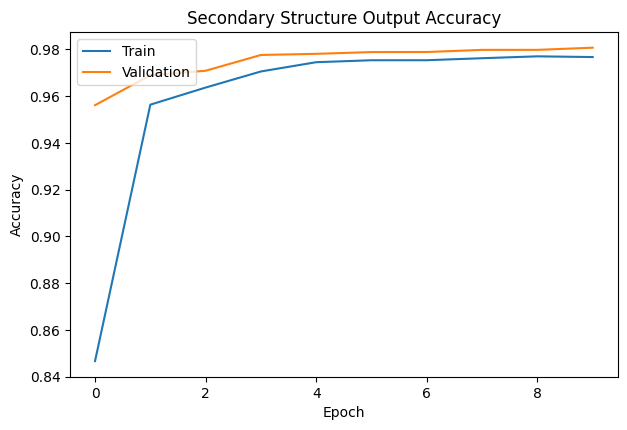

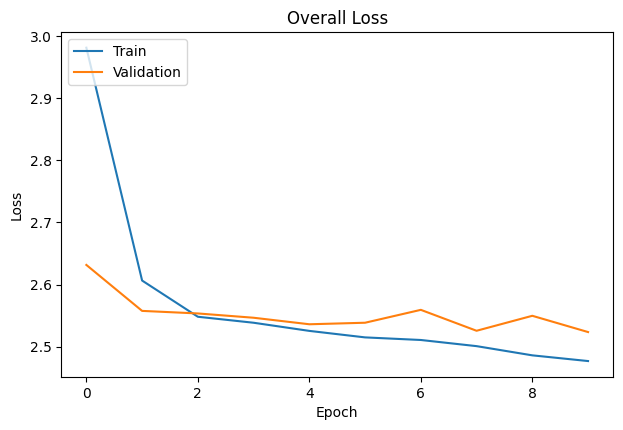

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for each output
plt.figure(figsize=(12, 8))

# # Region Output Accuracy
# plt.subplot(2, 2, 1)
# plt.plot(history.history['region_output_accuracy'])
# plt.plot(history.history['val_region_output_accuracy'])
# plt.title('Region Output Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Functional Effect Output Accuracy
# plt.subplot(2, 2, 2)
# plt.plot(history.history['functional_effect_output_accuracy'])
# plt.plot(history.history['val_functional_effect_output_accuracy'])
# plt.title('Functional Effect Output Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Off-Target Effect Output Accuracy
# plt.subplot(2, 2, 3)
# plt.plot(history.history['off_target_output_accuracy'])
# plt.plot(history.history['val_off_target_output_accuracy'])
# plt.title('Off-Target Effect Output Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Secondary Structure Output Accuracy
plt.subplot(2, 2, 4)
plt.plot(history.history['secondary_structure_output_accuracy'])
plt.plot(history.history['val_secondary_structure_output_accuracy'])
plt.title('Secondary Structure Output Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation loss values for each output
plt.figure(figsize=(12, 8))

# Overall Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# # Region Output Loss
# plt.subplot(2, 2, 2)
# plt.plot(history.history['region_output_loss'])
# plt.plot(history.history['val_region_output_loss'])
# plt.title('Region Output Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Functional Effect Output Loss
# plt.subplot(2, 2, 3)
# plt.plot(history.history['functional_effect_output_loss'])
# plt.plot(history.history['val_functional_effect_output_loss'])
# plt.title('Functional Effect Output Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Off-Target Effect Output Loss
# plt.subplot(2, 2, 4)
# plt.plot(history.history['off_target_output_loss'])
# plt.plot(history.history['val_off_target_output_loss'])
# plt.title('Off-Target Effect Output Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
import joblib

# To check the model performance on a random sequence from the validation set
random_idx = np.random.randint(0, X_test.shape[0])

# Extract the sequence, the corresponding true structure, and header
random_sequence = X_test[random_idx]
random_true_structure = y_test[random_idx]
random_header = headers_test[random_idx]

# Reshape the sequence array to match input requirements of the model (batch size of 1)
random_sequence = np.expand_dims(random_sequence, axis=0)
random_true_structure = np.expand_dims(random_true_structure, axis=0)

# Create and fit the LabelEncoder
all_structure_chars = list('.()')  # Add all unique characters that appear in structures
le_structures = LabelEncoder()
le_structures.fit(all_structure_chars)

# Print the classes to see the encoding
print("Classes and their encoded values:")
for i, class_label in enumerate(le_structures.classes_):
    print(f"Class '{class_label}': {i}")

# Save the LabelEncoder for later use
joblib.dump(le_structures, 'structure_label_encoder_LTSM_csv_v6_2905.joblib')

# Predict the structure using the model
predicted_structures = model.predict([random_sequence, random_true_structure])
predicted_structure_idx = np.argmax(predicted_structures[3], axis=-1).flatten()  # The fourth output is the secondary structure
decoded_predictions = structure_le.inverse_transform(predicted_structure_idx)

# Decode the true labels
true_structure_idx = np.argmax(random_true_structure, axis=-1).flatten()
decoded_true_structure = structure_le.inverse_transform(true_structure_idx)

# Calculate and print accuracy
accuracy = accuracy_score(true_structure_idx, predicted_structure_idx)
print(f"Accuracy: {accuracy:.2f}")

# Print results
print(f"Header: {random_header}")
print("Predicted Structure: ", ''.join(decoded_predictions))
print("Actual Structure:    ", ''.join(decoded_true_structure))

Classes and their encoded values:
Class '(': 0
Class ')': 1
Class '.': 2
1/1 [==============================] - 3s 3s/step
Accuracy: 1.00
Header: hsa-miR-548b-3p
Predicted Structure:  ((((((.......))))).(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((

In [ ]:
if len(decoded_predictions) != len(decoded_true_structure):
    print("Mismatch in length of structures.")
else:
    differences = [i for i, (pred, actual) in enumerate(zip(decoded_predictions, decoded_true_structure)) if pred != actual]
    if differences:
        print(f"Mismatch at positions: {differences}")
        print(f"Sequence length: {len(X_test[random_idx])}")
        print(f"Number of mismatches: {len(differences)}")
    else:
        print("No differences found - structures are identical.")

Mismatch at positions: [0, 6, 11, 12, 14, 19, 20, 21]
Sequence length: 6926
Number of mismatches: 8
